# Visualize Model Coefficients

**Gregory Way, 2019**

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(ggrepel))

In [2]:
process_coefficients <- function(coef_file) {
    coef_df <- readr::read_tsv(coef_file,
                               col_types=readr::cols(
                                   .default = readr::col_double(),
                                   features = readr::col_character())
                              )
    
    number_models_per_feature <- rowSums(coef_df > 0) %>% tibble::as_tibble()
    number_models_per_feature <- cbind(coef_df$features, number_models_per_feature)
    colnames(number_models_per_feature) <- c("features", "num_models_above_zero")
    
    coef_sums_df <- abs(coef_df %>% dplyr::select(-features)) %>%
        base::rowSums() %>% tibble::enframe() %>%
        dplyr::mutate(features = coef_df$features) %>%
        dplyr::select(-name) %>%
        dplyr::rename(value_sum = value) %>%
        dplyr::arrange(desc(value_sum)) %>%
        dplyr::left_join(number_models_per_feature, by = "features")
    
    split_coef_df <- coef_sums_df %>%
        tidyr::separate(features,
                        into=c("compartment",
                               "feature_group",
                               "measurement",
                               "channel", 
                               "parameter1", 
                               "parameter2"), sep="_") %>%
        dplyr::mutate(feature_id = coef_sums_df$features)

    split_coef_df$feature_id <- factor(split_coef_df$feature_id, levels=split_coef_df$feature_id)
    
    return(split_coef_df)
}

In [3]:
coef_file <- file.path("results", "all_model_coefficients.tsv")
coef_df <- process_coefficients(coef_file)

head(coef_df, 10)

Warning message:
“Calling `as_tibble()` on a vector is discouraged, because the behavior is likely to change in the future. Use `tibble::enframe(name = NULL)` instead.
This warning is displayed once per session.”Warning message:
“Column `features` joining character vector and factor, coercing into character vector”Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 693 rows [1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, ...].”

value_sum,compartment,feature_group,measurement,channel,parameter1,parameter2,num_models_above_zero,feature_id
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>
2.020495,Cells,RadialDistribution,RadialCV,ER,4of4,NA,6,Cells_RadialDistribution_RadialCV_ER_4of4
1.373074,Cytoplasm,Intensity,MADIntensity,Mito,NA,NA,4,Cytoplasm_Intensity_MADIntensity_Mito
1.336867,Cytoplasm,Texture,InfoMeas1,DNA,20,0,26,Cytoplasm_Texture_InfoMeas1_DNA_20_0
1.296178,Cytoplasm,AreaShape,Zernike,9,1,NA,7,Cytoplasm_AreaShape_Zernike_9_1
1.236882,Cells,Intensity,StdIntensityEdge,Mito,NA,NA,9,Cells_Intensity_StdIntensityEdge_Mito
1.158955,Cells,RadialDistribution,RadialCV,RNA,4of4,NA,5,Cells_RadialDistribution_RadialCV_RNA_4of4
1.121233,Nuclei,Granularity,12,DNA,NA,NA,23,Nuclei_Granularity_12_DNA
1.109007,Nuclei,Texture,DifferenceVariance,DNA,10,0,13,Nuclei_Texture_DifferenceVariance_DNA_10_0
1.072066,Cells,AreaShape,Zernike,5,3,NA,9,Cells_AreaShape_Zernike_5_3


In [4]:
coef_file <- file.path("results", "all_model_coefficients_shuffled.tsv")
coef_shuffle_df <- process_coefficients(coef_file)

head(coef_shuffle_df, 2)

Warning message:
“Column `features` joining character vector and factor, coercing into character vector”Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 693 rows [1, 6, 8, 10, 12, 14, 15, 17, 19, 20, 21, 24, 25, 26, 31, 32, 33, 35, 38, 39, ...].”

value_sum,compartment,feature_group,measurement,channel,parameter1,parameter2,num_models_above_zero,feature_id
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>
0.1238335,Cells,Intensity,IntegratedIntensityEdge,Mito,NA,NA,4,Cells_Intensity_IntegratedIntensityEdge_Mito
0.1217910,Cytoplasm,Texture,InfoMeas1,DNA,5,0,2,Cytoplasm_Texture_InfoMeas1_DNA_5_0


## Visualize Feature Importance

In [5]:
real_hist_gg <- ggplot(coef_df,
                       aes(x = value_sum)) +
    geom_histogram(bins = 100) +
    theme_bw() +
    xlab("Coefficient Sum (Real)") +
    ylab("Count")

shuffled_hist_gg <- ggplot(coef_shuffle_df, aes(x=value_sum)) +
    geom_histogram(bins = 100) +
    theme_bw() +
    xlab("Coefficient Sum (Shuffled)") +
    ylab("Count")

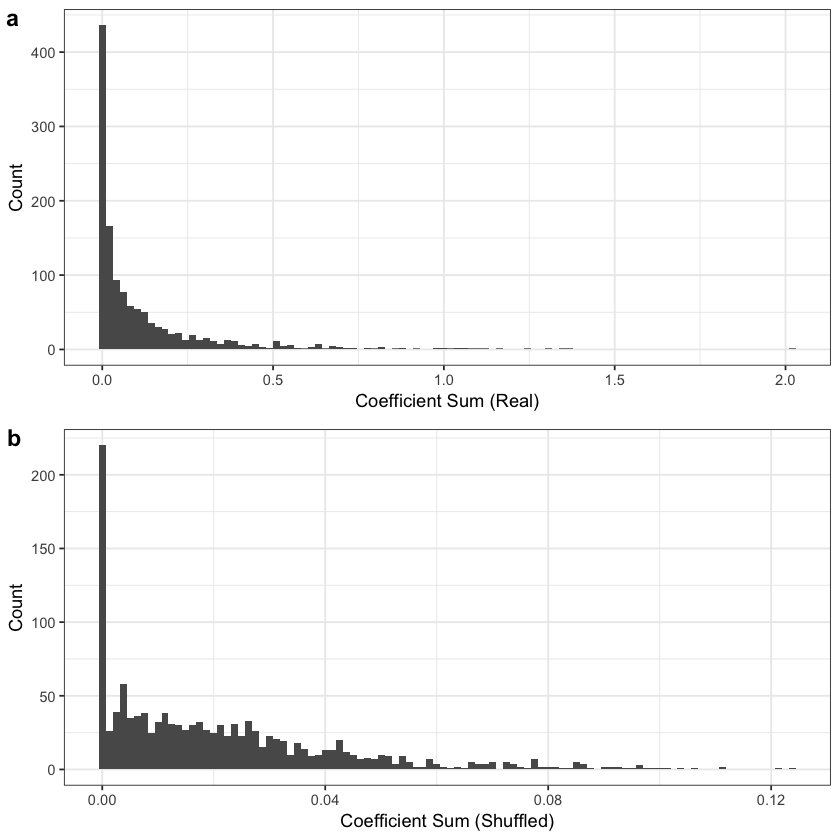

In [6]:
hist_gg <- cowplot::plot_grid(
    real_hist_gg,
    shuffled_hist_gg,
    ncol = 1,
    labels = c("a", "b")
)

hist_gg

In [7]:
coef_merge_df <- coef_df %>%
    dplyr::inner_join(coef_shuffle_df,
                      by = c("compartment", "feature_group", "measurement",
                             "channel", "parameter1", "parameter2", "feature_id"),
                      suffix = c("", "_shuffle"))

channels <- c("DNA", "AGP", "ER", "Mito", "RNA")
coef_merge_df[!coef_merge_df$channel %in% channels, "channel"] <- "NA"

head(coef_merge_df, 2)

Warning message:
“Column `feature_id` joining factors with different levels, coercing to character vector”

value_sum,compartment,feature_group,measurement,channel,parameter1,parameter2,num_models_above_zero,feature_id,value_sum_shuffle,num_models_above_zero_shuffle
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
2.020495,Cells,RadialDistribution,RadialCV,ER,4of4,NA,6,Cells_RadialDistribution_RadialCV_ER_4of4,0.004178398,2
1.373074,Cytoplasm,Intensity,MADIntensity,Mito,NA,NA,4,Cytoplasm_Intensity_MADIntensity_Mito,0.000000000,1


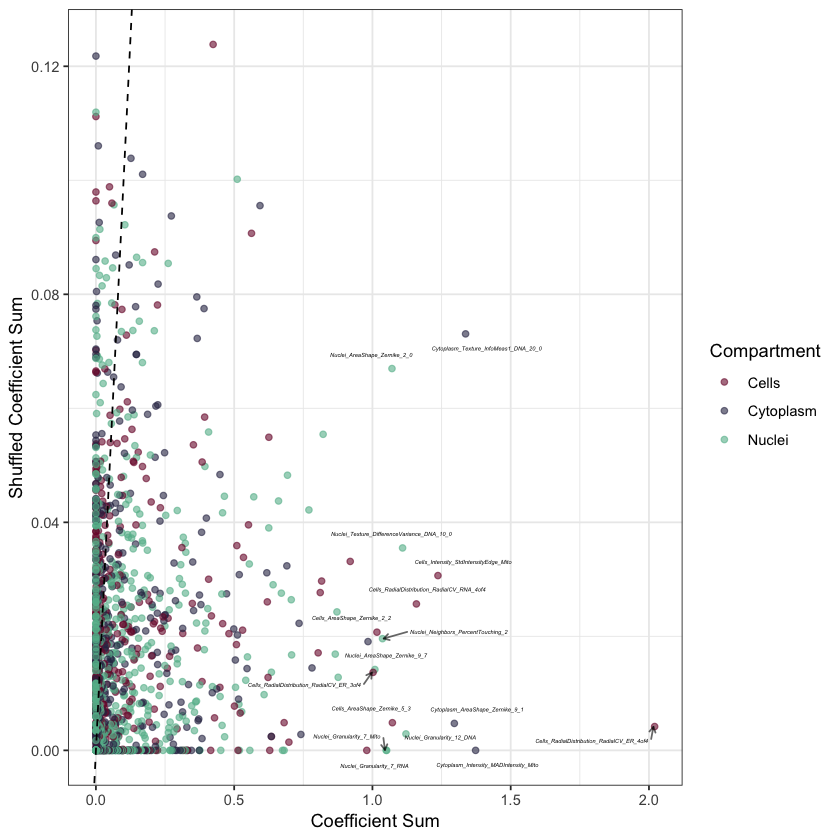

In [8]:
label_logic <- coef_merge_df$value_sum > 1

feature_distrib_gg <- ggplot(coef_merge_df,
                             aes(x = value_sum, y = value_sum_shuffle)) +
    geom_point(aes(color = compartment),
               alpha = 0.6) +
    xlab("Coefficient Sum") +
    ylab("Shuffled Coefficient Sum") +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed") +
    geom_text_repel(data = subset(coef_merge_df, label_logic),
                    arrow = arrow(length = unit(0.01, "npc")),
                    box.padding = 0.4,
                    point.padding = 0.1,
                    segment.size = 0.5,
                    segment.alpha = 0.6,
                    size = 1.2,
                    fontface = "italic",
                    aes(label = feature_id,
                        x = value_sum,
                        y = value_sum_shuffle)) +
    scale_color_manual(name = "Compartment",
                         values = c("Cells" = "#7B1336",
                                    "Cytoplasm" = "#313053",
                                    "Nuclei" = "#65B999")) +

    theme_bw()

feature_distrib_gg

In [9]:
coef_channel_mean <- coef_merge_df %>%
    dplyr::group_by(channel) %>%
    dplyr::mutate(channel_mean= mean(abs(value_sum)), 
                  channel_mean_shuffle = mean(abs(value_sum_shuffle))) %>%
    dplyr::distinct(channel, channel_mean, channel_mean_shuffle) %>%
    reshape2::melt(id.vars = 'channel',
                   variable.name = "channel_type",
                   value.name = "channel_mean")

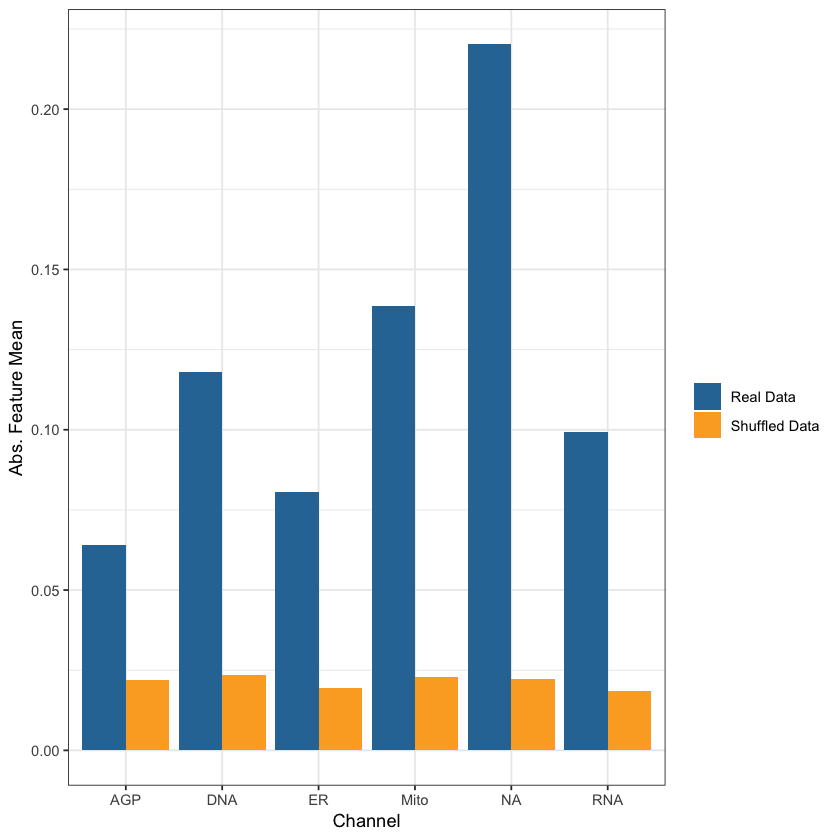

In [10]:
bar_coef_gg <- ggplot(coef_channel_mean, aes(x = channel, y = channel_mean, fill = channel_type)) +
    geom_bar(stat = "identity", position = position_dodge()) +
    xlab("Channel") +
    ylab("Abs. Feature Mean") +
    scale_fill_manual(name = "",
                      labels = c("channel_mean" = "Real Data",
                                 "channel_mean_shuffle" = "Shuffled Data"), 
                      values = c("channel_mean" = "#2B76A4",
                                 "channel_mean_shuffle" = "#FCAA2A")) +
    theme_bw()

bar_coef_gg

In [11]:
feature_type_gg <- cowplot::plot_grid(
    bar_coef_gg,
    feature_distrib_gg,
    ncol = 1,
    labels = c("c", "d")
)

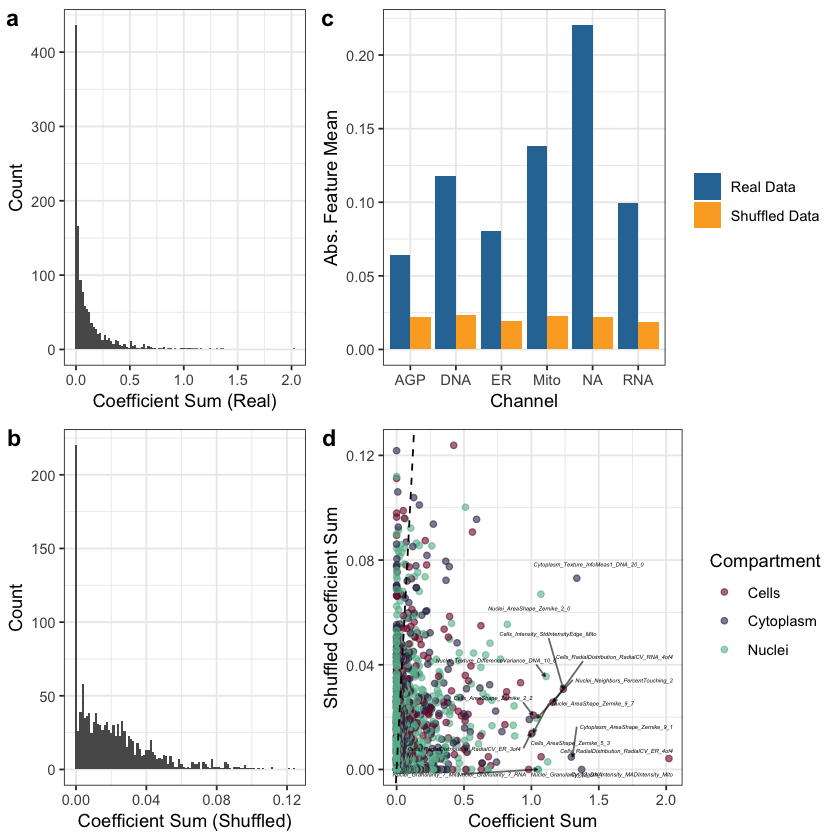

In [12]:
all_coef_gg <- cowplot::plot_grid(
    hist_gg,
    feature_type_gg,
    nrow = 1,
    rel_widths = c(0.6, 1)
)

all_coef_gg

In [13]:
cowplot_file <- file.path("figures", "model_coefficient_summary.png")

cowplot::save_plot(filename = cowplot_file,
                           plot = all_coef_gg,
                           base_height = 6,
                           base_width = 8)

## Visualize Coefficients

In [14]:
coef_all_df <- coef_df %>%
    dplyr::mutate(shuffle = "shuffle_false") %>%
    dplyr::bind_rows(
        coef_shuffle_df %>%
        dplyr::mutate(shuffle = "shuffle_true")
    )

print(dim(coef_all_df))
head(coef_all_df, 3)

[1] 2556   10


value_sum,compartment,feature_group,measurement,channel,parameter1,parameter2,num_models_above_zero,feature_id,shuffle
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>
2.020495,Cells,RadialDistribution,RadialCV,ER,4of4,NA,6,Cells_RadialDistribution_RadialCV_ER_4of4,shuffle_false
1.373074,Cytoplasm,Intensity,MADIntensity,Mito,NA,NA,4,Cytoplasm_Intensity_MADIntensity_Mito,shuffle_false
1.336867,Cytoplasm,Texture,InfoMeas1,DNA,20,0,26,Cytoplasm_Texture_InfoMeas1_DNA_20_0,shuffle_false


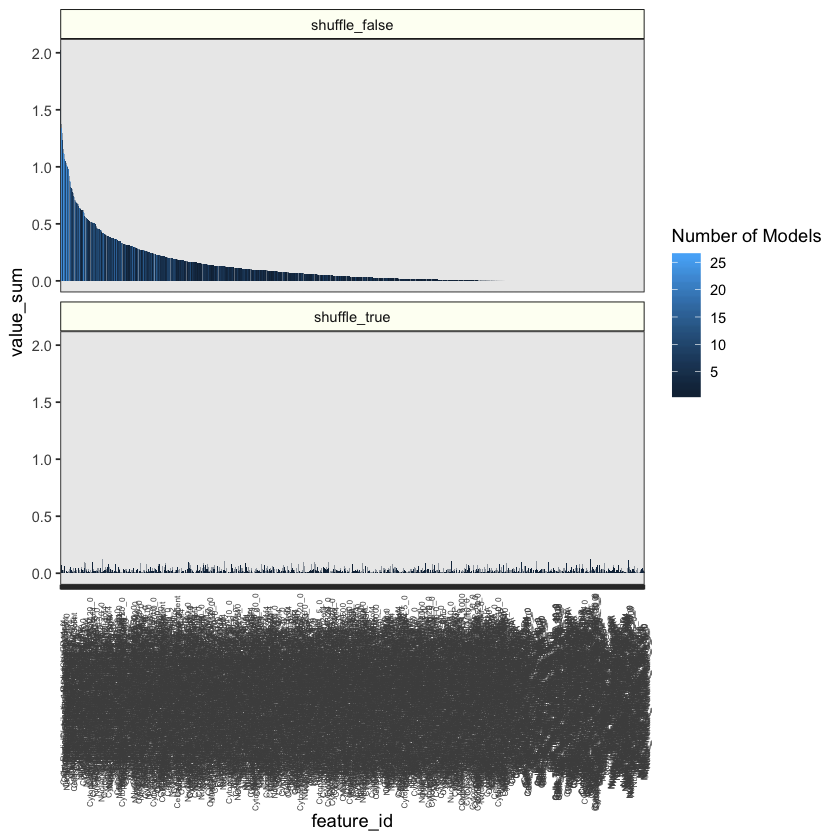

In [15]:
all_feature_gg <- ggplot(coef_all_df,
       aes(x = feature_id,
           y = value_sum)) +
    geom_bar(aes(fill = num_models_above_zero), stat="identity") +
    scale_fill_continuous(name = "Number of Models") +
    theme_bw() + 
    facet_wrap(~shuffle, ncol = 1) +
    theme(axis.text.x = element_text(size = 5, angle = 90),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path("figures", "coefficient_sum_full.png")
ggsave(output_file, all_feature_gg, height = 10, width = 18)

all_feature_gg

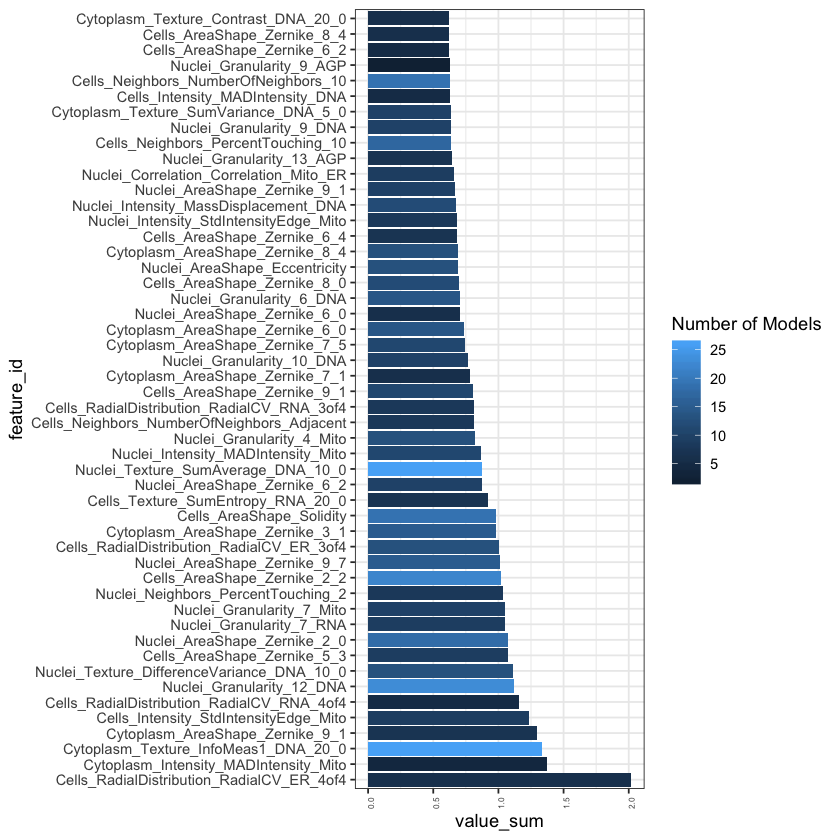

In [16]:
subset_feature_gg <- ggplot(coef_all_df %>%
                            dplyr::top_n(50, value_sum),
       aes(x = feature_id,
           y = value_sum)) +
    geom_bar(aes(fill = num_models_above_zero), stat="identity") +
    scale_fill_continuous(name = "Number of Models") +
    theme_bw() + 
    theme(axis.text.x = element_text(size = 5, angle = 90),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4")) +
    coord_flip()

output_file <- file.path("figures", "coefficient_sum_subset.png")
ggsave(output_file, subset_feature_gg, height = 8, width = 8)

subset_feature_gg